In [ ]:
# !pip install pyunpack
# !pip install patool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# from pyunpack import Archive
# Archive('/content/drive/My Drive/Data_Set_2(Black_and_white_images).rar').extractall('/content/drive/My Drive/Data_Set_2(Black_and_white_images)')

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [ ]:
class DatasetClass(Dataset):
    
    def __init__(self, folder, filename, label_dict):
        
        self.filename = filename
        self.data = pd.read_csv(folder + '/' + filename, header=None)
        self.y = torch.tensor(label_dict[self.filename.rstrip('.csv')], dtype=torch.long)
    
    def __getitem__(self, idx):     
        
        return torch.tensor(self.data.iloc[idx], dtype=torch.float), self.y
      
    def __len__(self):
        
        return len(self.data)

In [ ]:
def train_test_loader(directory, train_fraction=0.8, num_workers=2, batch_size=32):

    files = list(filter(lambda x: x.endswith('.csv') and x[0].isupper(), os.listdir(directory)))
    label_dict = {}

    i = 0
    for file in files:
        label_dict[file.rstrip('.csv')] = i
        i += 1

    datasets = list(map(lambda x : DatasetClass(directory, x, label_dict), files))
    dataset = ConcatDataset(datasets)
    N = dataset.cumulative_sizes[-1]
    
    train_size = int(N*train_fraction)
    test_size = N - train_size

    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return trainloader, testloader, train_size, test_size

In [ ]:
trainloader, testloader, train_size, test_size = train_test_loader('/content/drive/My Drive/Data_Set_2(Black_and_white_images)', train_fraction=0.8, num_workers=0, batch_size=64)

In [ ]:
class AutoEncoder(nn.Module):
    
    def __init__(self, n_features, h_layer_sizes):
        super(AutoEncoder, self).__init__()
        
        self.fc1 = nn.Linear(n_features, h_layer_sizes[0])
        self.fc2 = nn.Linear(h_layer_sizes[0], h_layer_sizes[1])
        self.fc3 = nn.Linear(h_layer_sizes[1], h_layer_sizes[2])
        self.out = nn.Linear(h_layer_sizes[2], n_features)
        
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x)) # Hidden Layer 1 (Tanh)
        x = self.fc2(x)    # Hidden Layer 2 (Linear)
        x = torch.tanh(self.fc3(x)) # Hidden Layer 3 (Tanh)
        x = self.out(x) # Output Layer (Linear)
        
        return x
    
    def get_z(self, x):
        
        z = torch.tanh(self.fc1(x))
        z = self.fc2(z)
        
        return z

In [ ]:
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
ae1 = AutoEncoder(784, [150, 300, 150])
ae1 = ae1.to(device)
optimizer1 = optim.SGD(ae1.parameters(), lr=0.001, momentum=0.8)

In [ ]:
nn.init.xavier_normal_(ae1.fc1.weight)
nn.init.xavier_normal_(ae1.fc2.weight)
nn.init.xavier_normal_(ae1.fc3.weight)
nn.init.xavier_normal_(ae1.out.weight)

Parameter containing:
tensor([[-0.0473,  0.0143, -0.0267,  ...,  0.0494,  0.0549, -0.0022],
        [-0.0727, -0.0053,  0.0683,  ...,  0.0236,  0.0278,  0.0068],
        [ 0.0310,  0.0680,  0.0771,  ...,  0.0087,  0.0730, -0.0665],
        ...,
        [ 0.0289,  0.0029,  0.0511,  ..., -0.0339, -0.0300, -0.0316],
        [ 0.0183,  0.0044,  0.0534,  ..., -0.0003,  0.0149,  0.0453],
        [ 0.0992,  0.0698, -0.0617,  ...,  0.0015, -0.0276,  0.0216]],
       device='cuda:0', requires_grad=True)

In [ ]:
old_loss = np.inf

max_epoch = 50

for epoch in range(max_epoch):

    running_loss = 0.0
    len_ = 0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        optimizer1.zero_grad()
        
        # Reconstructed Representation of X (forward)
        X_hat = ae1(X)
        
        # Calculate Loss (MSE)
        loss = criterion(X_hat, X)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer1.step()
        
        running_loss += loss.item()*len(X)
    
    print('Epoch', epoch+1, ': Loss =', running_loss/train_size)
    
    if (abs(running_loss-old_loss)/running_loss < 1e-5):
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 8262.5158515625
Epoch 2 : Loss = 5816.47699609375
Epoch 3 : Loss = 5684.198220052083
Epoch 4 : Loss = 5665.770877604166
Epoch 5 : Loss = 5672.217048828125
Epoch 6 : Loss = 5679.772602213542
Epoch 7 : Loss = 5656.240639973958
Epoch 8 : Loss = 5656.17103125
Epoch 9 : Loss = 5653.755246744791
Epoch 10 : Loss = 5653.284908203125
Epoch 11 : Loss = 5653.759967447917
Epoch 12 : Loss = 5653.584149739583
Epoch 13 : Loss = 5653.262468098958
Epoch 14 : Loss = 5653.269096354166
Converged
Finished Training


In [ ]:
X_data_test = []
X_data_test_pred = []

test_loss = 0.0
len_ = 0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      X_pred = ae1(X)
      loss = criterion(X_pred, X)

    test_loss += loss.item()*len(X)

test_loss = test_loss/test_size
print(test_loss)

5628.567348958333


In [ ]:
Z1_array = []

for data in trainloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z1 = ae1.get_z(X)

    if len(Z1_array) == 0:
        Z1_array = Z1.cpu().numpy()
    else:
        Z1_array = np.append(Z1_array, Z1.cpu().numpy(), axis=0)

In [ ]:
Z1_array.shape

(48000, 300)

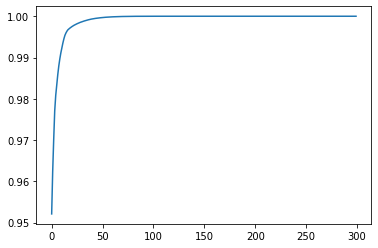

In [ ]:
pca2 = PCA(n_components=300)
pca2.fit(Z1_array)

explained_var = np.cumsum(pca2.explained_variance_ratio_)
plt.plot(explained_var)
plt.show()

In [ ]:
explained_var

array([0.95209974, 0.9623871 , 0.9701707 , 0.977094  , 0.9808555 ,
       0.98345304, 0.98586243, 0.9879532 , 0.98965275, 0.99109817,
       0.9923194 , 0.9934919 , 0.99452   , 0.9953611 , 0.9959334 ,
       0.99637777, 0.99672544, 0.99694437, 0.9971484 , 0.99733377,
       0.9975059 , 0.99767023, 0.99781525, 0.9979479 , 0.9980756 ,
       0.99819076, 0.9983023 , 0.9984097 , 0.9985084 , 0.9986003 ,
       0.9986875 , 0.9987706 , 0.99885154, 0.998927  , 0.9989986 ,
       0.9990685 , 0.9991352 , 0.9991988 , 0.99925715, 0.99930656,
       0.9993537 , 0.9993996 , 0.99944085, 0.99947876, 0.99951476,
       0.999547  , 0.9995788 , 0.9996076 , 0.9996358 , 0.99966383,
       0.99968946, 0.99971217, 0.99973357, 0.9997537 , 0.99977213,
       0.9997887 , 0.9998047 , 0.99982   , 0.9998346 , 0.9998474 ,
       0.9998596 , 0.99987096, 0.99988115, 0.99989104, 0.99990064,
       0.9999094 , 0.9999174 , 0.99992436, 0.9999306 , 0.99993664,
       0.9999421 , 0.99994725, 0.99995184, 0.99995595, 0.99995

In [ ]:
ae2 = AutoEncoder(300, [150, 100, 150])
optimizer2 = optim.SGD(ae2.parameters(), lr=0.001, momentum=0.9)
ae2 = ae2.to(device)

In [ ]:
old_loss = np.inf

max_epoch = 500

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            Z = ae1.get_z(X)
        
        optimizer2.zero_grad()
        
        # Reconstructed Representation of X (forward)
        Z_hat = ae2(Z)
        
        # Calculate Loss (MSE)
        loss = criterion(Z_hat, Z)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer2.step()
        
        running_loss += loss.item()
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 1e-3:
        print('Converged')
        break
        
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 980.7005815608427
Finished Training


In [ ]:
ae3 = AutoEncoder(100, [75, 50, 75])
optimizer3 = optim.SGD(ae3.parameters(), lr=0.001, momentum=0.9)
ae3 = ae3.to(device)

In [ ]:
old_loss = np.inf

max_epoch = 500

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            Z1 = ae1.get_z(X)
            Z = ae2.get_z(Z1)
        
        optimizer3.zero_grad()
        
        # Reconstructed Representation of Z (forward)
        Z_hat = ae3(Z)
        
        # Calculate Loss (MSE)
        loss = criterion(Z_hat, Z)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer3.step()
        
        running_loss += loss.item()
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 1e-3:
        print('Converged')
        break
        
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 410.4300510010253
Finished Training


In [ ]:
class FinalNet(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FinalNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.out = nn.Linear(hidden_sizes[3], num_classes)
    
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.out(x)
        
        return x
    
    def predict(self, X):
        
        with torch.no_grad():
            y_score = self.forward(X)
            y_pred = torch.argmax(y_score, axis=1)
            
        return y_pred
            
    
classifier = FinalNet(784, [300, 150, 75, 50], 10)

In [ ]:
ae1_params = list(ae1.parameters())
ae2_params = list(ae2.parameters())
ae3_params = list(ae3.parameters())

with torch.no_grad():
    
    classifier.fc1.weight.data = nn.Parameter(ae1_params[0])
    classifier.fc1.bias.data = nn.Parameter(ae1_params[1])
    
    classifier.fc2.weight = nn.Parameter(torch.matmul(ae2_params[0], ae1_params[2]))
    classifier.fc2.bias = nn.Parameter(torch.matmul(ae2_params[0], ae1_params[3]) + ae2_params[1])
    
    classifier.fc3.weight = nn.Parameter(torch.matmul(ae3_params[0], ae2_params[2]))
    classifier.fc3.bias = nn.Parameter(torch.matmul(ae3_params[0], ae2_params[3]) + ae3_params[1])
    
    classifier.fc4.weight = nn.Parameter(ae3_params[2])
    classifier.fc4.bias = nn.Parameter(ae3_params[3])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
classifier = classifier.to(device)

In [ ]:
old_loss = np.inf

max_epoch = 500

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 1e-3:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 3457.114572763443
Finished Training


In [ ]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        test_loss += criterion(y_hat, y)
        
        y_test.extend(list(y.detach().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 864.0877075195312


,0,1,2,3,4,5,6,7,8,9
0,0,0,1215,0,0,0,0,0,0,0
1,0,0,1234,0,0,0,0,0,0,0
2,0,0,1191,0,0,0,0,0,0,0
3,0,0,1251,0,0,0,0,0,0,0
4,0,0,1179,0,0,0,0,0,0,0
5,0,0,1138,0,0,0,0,0,0,0
6,0,0,1172,0,0,0,0,0,0,0
7,0,0,1228,0,0,0,0,0,0,0
8,0,0,1196,0,0,0,0,0,0,0
9,0,0,1196,0,0,0,0,0,0,0
